# Spatial evaluation and model architecture

Linear regression, covered in the previous chapter, is often seen as an
entry method to enter the world of supervised machine learning. However,
not every phenomenon can be explained using a linear relationship, and
not everything is a regression. For the former, you need to use methods
that have a bit more complicated math behind them (but often the same
Python API). For the latter, you will often need to look for
classification models. Both of these options are covered in this course,
with non-linear regression models in this session and classification in
the next one. Today, you’ll focus on learning the API and the key
principles of supervised machine learning with scikit-learn and
especially on spatial evaluation of model performance. To a degree, it
is a continuation of the work covered last time, but there are some new
things here and there.

> **This is not an introduction to ML**
>
> Note that this material does not aim to cover an introduction to
> machine learning thoroughly. There are other, much better materials
> for that. One of them can be [scikit-learn’s User
> guide](https://scikit-learn.org/stable/user_guide.html), but I am sure
> you will find one that suits you.

In [178]:
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterpolate
from libpysal import graph
from sklearn import ensemble, metrics, model_selection
import tobler
import contextily


In [179]:
prices = pd.read_excel('prices.xlsx')

In [180]:
#read as geodataframe

prices = gpd.GeoDataFrame(
    prices,
    geometry=gpd.points_from_xy(
        prices["Longitude"], prices["Latitude"], crs="EPSG:4326"
    ),
)
prices.head(2)

,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,...,Population,Pop. Density,Higher Degree,Young Population,Median Age,Old Population,Spring,Fall,Winter,geometry
0,9.798127,129.108144,35.215019,45.07,8,13.0,84.0,0.67,0,2017,...,31022,1637.044855,46.392339,26.284572,55.4,5.712075,0,0,1,POINT (129.10814 35.21502)
1,9.852194,129.108144,35.215019,38.10,13,13.0,84.0,0.67,0,2017,...,31022,1637.044855,46.392339,26.284572,55.4,5.712075,1,0,0,POINT (129.10814 35.21502)


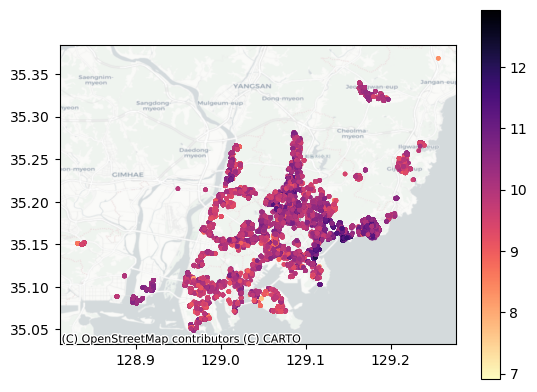

In [181]:
ax = prices.plot(
    'Property Prices',
    legend=True,
    vmin=prices['Property Prices'].min(),
    vmax=prices['Property Prices'].max(),
    cmap='magma_r',
    markersize=5,
)
contextily.add_basemap(ax=ax, crs=prices.crs, source="CartoDB Positron")

plt.show()

## Data

Let’s stick to a similar type of data you were working with in the
previous chapter on linear regression. The data you will be working with
today is, once again, representing municipalities in Czechia but this
time your task will not be prediction of election results but the rate
of executions (of any kind, not only those related to mortgages). The
dataset is representing the proportion of population aged 15 and above
in each municipality with at least one court mandated execution during
the Q3 of 2024, coming from
[mapazadluzeni.cz](https://www.mapazadluzeni.cz) by PAQ Research. The
CSV is only slightly pre-processed to contain only relevant information.

The `executions_data` GeoDataFrame has obviously more columns than we
need. For the modelling purpose, select a subset of variables to treat
as independent, explanatory. The election results of Andrej Babiš, three
columns representing education levels, mean age and divorced rate.

In [182]:
independant_variables = ['Size', 'Floor', 'Units', 'Parking', 'Dist. Green', 'Heating', 'Dist. Subway', 'Bus Stop', 'High School']

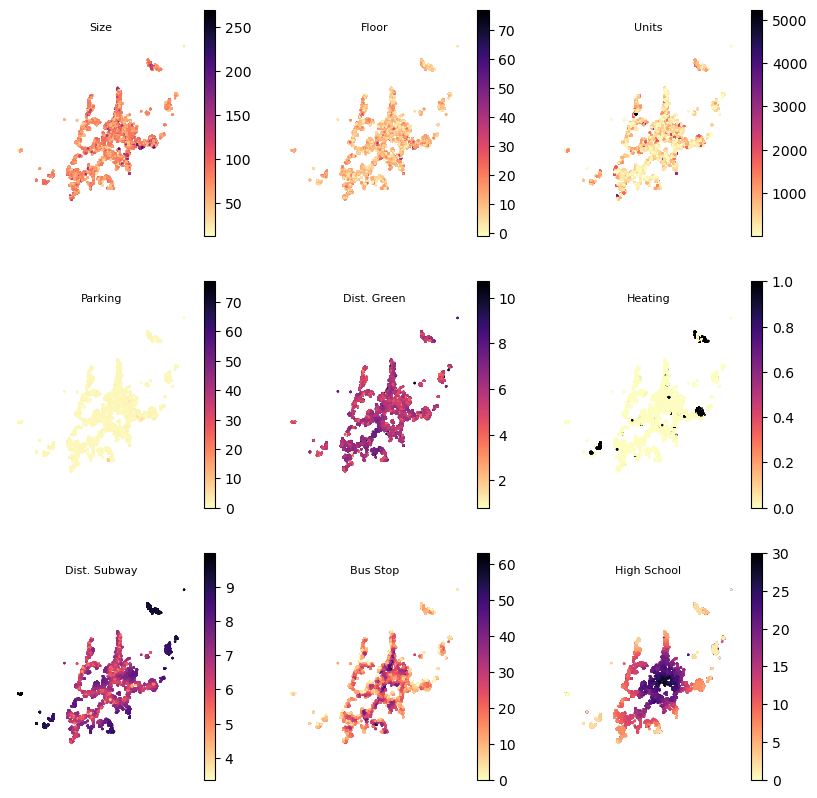

In [183]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for variable, ax in zip(independant_variables, axs.flatten()):
    prices.plot(
        variable,
        ax=ax,
        cmap="magma_r",
        legend=True,
        markersize=0.5
    )
    ax.set_title(variable, fontdict={"fontsize": 8})
    ax.set_axis_off()

## Machine learning 101

As mentioned above, this material is not meant to provide exhaustive
introduction to machine learning. Yet, some basics shall be explained.
Start with storing independent variables and a target variable
separately.

In [184]:
independent = prices[independant_variables]
target = prices['Property Prices']

### Train-test split

Some data are used to train the model, but the same data cannot be used
for evaluation. The models tend to learn those exact values, and the
performance metrics derived from training data show a much higher score
than the model can on unseen data. One way around this is to split the
dataset into two parts - `train` and `test`. The `train` part is used to
train the model. However, the `test` part is left out of training and is
later used to evaluate performance without worrying that any of the data
points were seen by the model before.

`scikit-learn` offers handy function to split the data into train and
test parts, dealing with both dependent and independent variables at the
same time.

In [185]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    independent, target, test_size=0.2, random_state=0
)
X_train.head()

,Size,Floor,Units,Parking,Dist. Green,Heating,Dist. Subway,Bus Stop,High School
16219,23.4500,9,131.0,0.30,10.058553,0,5.844617,24,25
34747,67.7474,12,224.0,1.06,5.743311,0,6.195071,15,21
34673,23.7500,12,264.0,0.36,6.325125,0,5.655495,36,22
34615,49.0800,4,2960.0,0.84,4.605739,0,6.093589,8,4
3004,84.9640,18,565.0,1.11,10.487516,0,6.453658,6,2


You can check that `X_*`, containing independent variables is split into
two parts, one with 80% of the data and the other with remaining 20%.
Completely randomly.

In [186]:
X_train.shape, X_test.shape

((42115, 9), (10529, 9))

### Training

While there is a large number of ML models available, your goal at the
moment is not to understand which ML model is better and how to
fine-tune it but how to evaluate it using the spatial dimension. So,
let’s not complicate the situation and stick to one of the common
models - [random forest](https://en.wikipedia.org/wiki/Random_forest).

Random forest regressor is implemented within the `ensemble` module of
the `scikit-learn` and has the API you should already be familiar with.
Get the training data and fit the baseline model.

In [187]:

basic_model = ensemble.RandomForestRegressor(n_jobs=-1, random_state=0)
basic_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

1.  `n_jobs=-1` specifies that the algorithm should use all available
    cores. Otherwise, it runs in a single thread only. There are also
    some model parameters to play with but more on that below.
2.  The first argument is a 2-D array of independent variables, and the
    second is a 1-D array of labels you want to predict.

### Predicting

The trained model can be directly used to predict the value, the
proportion of executions. Normally, you do the prediction using the
unseen portion of the data from the train-test split.

In [188]:
pred_test = basic_model.predict(X_test)
pred_test

array([ 9.68292153, 10.79103658, 11.58200299, ..., 10.72542119,
        9.35575754, 10.30320876])

The output is a simple numpy array aligned with the values from
`X_test`. What this array is mostly used for is the model evaluation.

### Evaluation

Evaluation is usually composed a series of measurements comparing the
expected and predicted values and assessing how close the result is.
Regression problems typically use $R^2$, *mean absolute error*, or *root
mean squared error* among others. Let’s stick to these three for now.
All are directly implemented in scikit-learn.

#### R-squared

$R^2$ is a measure you should already be familiar with from the previous
session on linear regression. It expresses the proportion of variation
of the target variable that could be predicted from the independent
variables.

In [189]:
r2 = metrics.r2_score(y_test, pred_test)
r2

0.9609717633454922

This baseline model is able to explain about 56% of variation. Not bad,
given the limited data and no fine-tuning.

#### Mean absolute error

The name kind of says it all. The mean absolute error (MAE) reports how
far, on average, is the predicted value from the expected one. All that
directly in the units of the original target variable, making it easy to
interpret.

In [190]:
mean_absolute_error = metrics.mean_absolute_error(y_test, pred_test)
mean_absolute_error

0.07212955541448973

Here, you can observe that the error is about 1.6% on average. But given
the average rate of executions is 4.95%, it is quite a bit of spread.

#### Root mean squared error

Root mean squared error (RMSE) is a very similar metric but it is more
sensitive to larger errors. Therefore, if there is a smaller proportion
of observations that are *very off*, RMSE will penalise the resulting
performance metric more than MAE.

In [191]:
rmse = metrics.root_mean_squared_error(y_test, pred_test)
rmse

0.11111572505047775

It is a bit larger than MAE in this case, meaning that there are
outliers with exceptionally high residuals. You’ll be looking at
multiple models and evaluations, so let’s start building a summary
allowing simple reporting and comparison.

In [192]:
summary = f"""\
Evaluation metrics
==================
Random Forest:
  R2:   {round(r2, 3)}
  MAE:  {round(mean_absolute_error, 3)}
  RMSE: {round(rmse, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.961
  MAE:  0.072
  RMSE: 0.111



In [193]:
# feature importance
feature_importance = basic_model.feature_importances_
feature_importance = pd.Series(feature_importance, index=independent.columns)
feature_importance.sort_values(ascending=False)

Size            0.561630
Parking         0.212678
Dist. Subway    0.079562
Units           0.076845
Dist. Green     0.017196
High School     0.014855
Bus Stop        0.014388
Floor           0.013733
Heating         0.009115
dtype: float64

## Cross validation

Now, if you want to plot the predicted labels on a map, you can do that
reliably only for the test sample. The training sample was seen by the
model and would not be representative of model capabilities.

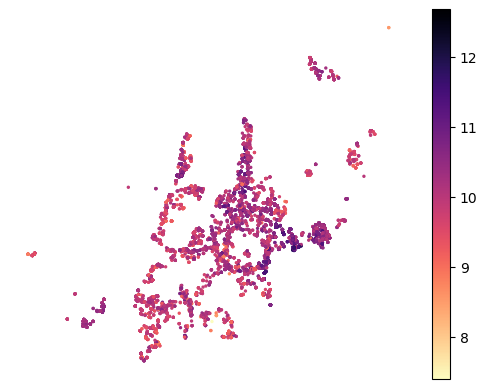

In [194]:
prices.assign(
    pred_test=pd.Series(pred_test, index=X_test.index)
).plot("pred_test", legend=True, markersize = 2, cmap='magma_r').set_axis_off()

Working with this would be a bit tricky if we want to look into the
spatial dimension of the model error.

However, you can create a map using the complete sample, just not using
exactly the same model for all its parts. Welcome cross-validated
prediction.

Cross-validated (CV) prediction splits the dataset (before you divided
it into train and test) into a small number of parts and trains a
separate model to predict values for each of them. In the example below,
it creates five equally-sized parts and then takes four of them as
*train* part to train a model that is used to predict values on the
fifth one. Then, it switches the one that is left out and repeats the
process until there are predicted values for every part. The resulting
prediction should not contain any data leakage between train and test
samples. However, as described below, that is not always the case when
dealing with spatial data.

In [195]:
pred_cross_val = model_selection.cross_val_predict(
    basic_model,
    independent,
    target,
    n_jobs=-1,
)
pred_cross_val

array([9.74895181, 9.68377345, 9.74692384, ..., 9.68631992, 9.84983435,
       9.87039321])

The array `pred_cross_val` now has the same length as the original data
and can be therefore plotted on a full map.

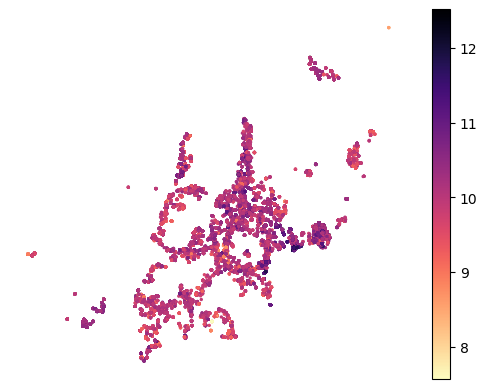

In [196]:
prices.plot(pred_cross_val, legend=True, markersize = 2, cmap='magma_r').set_axis_off()

Cross-validation also allows you to assess the quality of the model more
reliably, minimising the effect of sampling on the metric. You can
simply measure the performance on the full array taking into account
every of the five folds.

In [197]:
r2_cross_val = metrics.r2_score(
    target, pred_cross_val
)
mae_cross_val = metrics.mean_absolute_error(
    target, pred_cross_val
)
rmse_cross_val = metrics.root_mean_squared_error(
    target, pred_cross_val
)

summary += f"""\
Random Forest (k-fold metrics):
  R2:   {round(r2_cross_val, 3)}
  MAE:  {round(mae_cross_val, 3)}
  RMSE: {round(rmse_cross_val, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.961
  MAE:  0.072
  RMSE: 0.111
Random Forest (k-fold metrics):
  R2:   0.856
  MAE:  0.159
  RMSE: 0.215



These results are not wildly off but the performance dropped a bit. The
smaller the dataset (and this one is pretty small) the higher the effect
of train-test split could be. Let’s refer to the cross-validated metrics
as more reliable representation of the performance of the baseline model
here.

### Residuals

Another positive aspect of cross validation is that is allows use to
retrieve a full sample of residuals. Unlike in linear regression, where
residuals are part of the model, here you have to compute them yourself
as a difference between expected and a predicted value.

In [198]:
residuals = (target - pred_cross_val)
residuals.head()

0    0.049175
1    0.168421
2   -0.005955
3    0.114354
4    0.017910
Name: Property Prices, dtype: float64

Negative values mean the model have over-predicted the value, while the
positive one means under-prediction. The optimal is zero. Check the
residuals on a map.

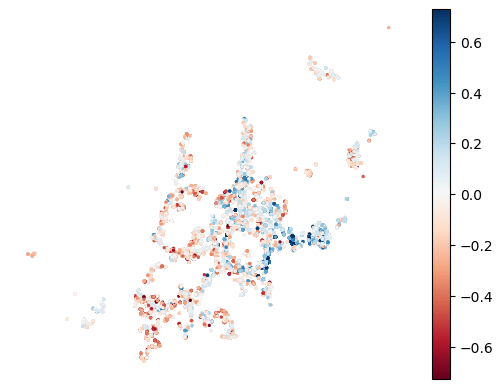

In [199]:
minmax = residuals.abs().std()
prices.plot(
    residuals,
    vmin=-minmax * 5,
    vmax=minmax * 5,
    cmap="RdBu",
    legend=True,
    markersize=2
).set_axis_off()

The spatial pattern of error signifies issues, you should know that from
the last session. You can optionally use some strategies covered there
to mitigate it. Today, let’s look and more advanced spatial evaluation
of the model performance.

## Spatial evaluation

The metrics reported above are global. A single value per model but the
map indicates that this varies in space. Let’s see how.

### Spatially stratified metrics

Global metrics can be computed on regional subsets. We have an
information about *okres* (county) and can try computing the metrics for
each individual *okres*. To make it all a bit easier, assign the
cross-validated prediction as a new column.

In [200]:
prices["prediction"] = pred_cross_val

In [ ]:
extent = prices.dissolve().concave_hull(ratio=0.1)

grid = tobler.util.h3fy(extent, resolution=7, buffer=20)
m = grid.explore()
prices.explore(m=m, color="red")


In [202]:
joined = gpd.sjoin(grid, prices)
#all columns

numeric_columns = joined.columns[2:]
mean_values = joined.groupby("hex_id")[numeric_columns].mean()
price_on_grid = grid.join(mean_values, on="hex_id")


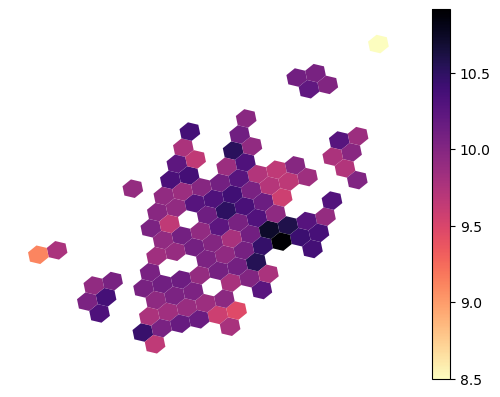

In [203]:
price_on_grid.plot("prediction", legend=True, cmap='magma_r').set_axis_off()

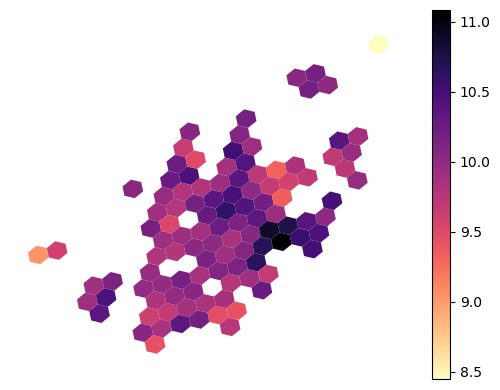

In [204]:
price_on_grid.plot("Property Prices", legend=True, cmap='magma_r').set_axis_off()

In [205]:
price_on_grid

,geometry,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,...,Population,Pop. Density,Higher Degree,Young Population,Median Age,Old Population,Spring,Fall,Winter,prediction
hex_id,,,,,,,,,,,,,,,,,,,,,
8730c1614ffffff,"POLYGON ((128.96507 35.1912, 128.96756 35.1813...",9.906952,128.988850,35.189249,58.586997,10.150685,15.493151,100.095890,0.885205,0.000000,...,29232.027397,15687.252152,28.072045,10.914315,45.364384,16.401529,0.410959,0.219178,0.082192,9.970903
8730c1615ffffff,"POLYGON ((128.98947 35.19588, 128.99196 35.186...",9.773196,128.999448,35.194829,75.641944,9.290970,17.956522,830.456522,0.802642,0.006689,...,24496.724080,11375.421733,25.977091,10.817126,42.664883,15.559903,0.270903,0.292642,0.230769,9.920523
8730c1628ffffff,"POLYGON ((129.06369 35.2566, 129.06618 35.2467...",10.513586,129.087147,35.253063,93.752150,11.287411,22.935867,1423.847981,1.292827,0.000000,...,32820.684086,13927.062935,36.464070,12.746859,44.771021,15.324555,0.168646,0.425178,0.232779,10.523748
8730c1686ffffff,"POLYGON ((128.9387 35.09293, 128.9412 35.08304...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8730c1620ffffff,"POLYGON ((128.99892 35.25972, 129.00141 35.249...",9.660495,129.016243,35.257079,61.470966,11.241791,21.850746,831.670149,0.699373,0.000000,...,34581.561194,12621.067781,26.871291,10.959731,43.822239,18.166126,0.247761,0.311940,0.216418,9.770382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730c1795ffffff,"POLYGON ((128.81873 35.16304, 128.82122 35.153...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8730c1663ffffff,"POLYGON ((129.18582 35.27983, 129.18831 35.269...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8730c168dffffff,"POLYGON ((129.0363 35.11164, 129.03879 35.1017...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:

price_on_grid = price_on_grid.dropna()

Using `groupby`, you can group the data by `"okres"` and check the
metric within each one. Better to measure metrics derived from real
values than $R^2$ as the latter is not well comparable across different
datasets (each *okres* would be its own dataset in this logic).

In [207]:
grouped = price_on_grid.groupby("hex_id")[
    ["Property Prices", "prediction"]
]


block_mae = grouped.apply(
    lambda group: metrics.mean_absolute_error(
        group["Property Prices"], group["prediction"]
    )
)
block_rmse = grouped.apply(
    lambda group: metrics.root_mean_squared_error(
        group["Property Prices"], group["prediction"]
    )
)

In [208]:
grouped.head()

,Property Prices,prediction
hex_id,,
8730c1614ffffff,9.906952,9.970903
8730c1615ffffff,9.773196,9.920523
8730c1628ffffff,10.513586,10.523748
8730c1620ffffff,9.660495,9.770382
8730c160effffff,10.469387,10.399506
...,...,...
8730c16abffffff,9.850297,9.903494
8730c1640ffffff,9.704387,9.767639
8730c1681ffffff,9.991192,10.048915


As a result, you now have two Series with the metric per *okres*.

In [209]:
block_mae.head()

hex_id
8730c1280ffffff    0.051725
8730c1296ffffff    0.002452
8730c1600ffffff    0.180427
8730c1601ffffff    0.167455
8730c1602ffffff    0.097430
dtype: float64

Let’s concatenate them together to a single DataFrame with proper column
names.

In [210]:
spatial_metrics = pd.concat([block_mae, block_rmse], axis=1)
spatial_metrics.columns = ["block_mae", "block_rmse"]
spatial_metrics.head(3)

,block_mae,block_rmse
hex_id,,
8730c1280ffffff,0.051725,0.051725
8730c1296ffffff,0.002452,0.002452
8730c1600ffffff,0.180427,0.180427


And merge with the original data. The spatial metrics cannot be simply
assigned as new columns as they are much shorter - only one value per
*okres*. You need to merge on the *okres* values to assign it as new
columns.

In [211]:
prices_data = price_on_grid.merge(
    spatial_metrics, left_on="hex_id", right_index=True
)
prices.head(3)



,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,...,Pop. Density,Higher Degree,Young Population,Median Age,Old Population,Spring,Fall,Winter,geometry,prediction
0,9.798127,129.108144,35.215019,45.07,8,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,0,0,1,POINT (129.10814 35.21502),9.748952
1,9.852194,129.108144,35.215019,38.10,13,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,1,0,0,POINT (129.10814 35.21502),9.683773
2,9.740969,129.108144,35.215019,45.07,6,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,1,0,0,POINT (129.10814 35.21502),9.746924


Let’s see how the performance differs across space.

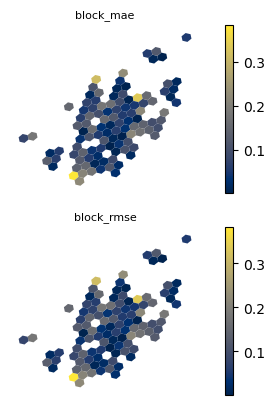

In [212]:
fig, axs = plt.subplots(2, 1)
for i, metric in enumerate(["block_mae", "block_rmse"]):
    prices_data.plot(metric, ax=axs[i], legend=True, cmap="cividis")
    axs[i].set_title(metric, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

The spatial variation is evident. What is also evident are the
boundaries between individual *okres*’s, suggesting a MAUP issue. At the
same time, such an aggregation may not always be available.

The better option is to measure the spatial metrics using the `Graph`.
You can define neighborhoods and measure the metric in each neighborhood
individually, reporting a unique value per each focal geometry. In this
case, you can assume that the daily mobility is not limited to
neighbouring municipalities only, so let’s get a K-nearest neighbors
with 100 neighbor (median number of municipalities in the *okres* is 79,
so it should cover roughly similar scale). Using very small
neighborhoods may result in the metrics jumping up and down erratically
due to sampling issue.

In [213]:
knn100 = graph.Graph.build_knn(
    prices_data.set_geometry(prices_data.centroid), 100
).assign_self_weight()

prices_data["spatial_mae"] = knn100.apply(
    prices_data[["Property Prices", "prediction"]],
    lambda df: metrics.mean_absolute_error(
        df["Property Prices"], df["prediction"]
    ),
)
prices_data["spatial_rmse"] = knn100.apply(
    prices_data[["Property Prices", "prediction"]],
    lambda df: metrics.root_mean_squared_error(
        df["Property Prices"], df["prediction"]
    ),
)

/var/folders/gl/6m73nrcs3yqd6q9dyxldg7th0000gn/T/ipykernel_4758/2465139050.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prices_data.set_geometry(prices_data.centroid), 100


You can map the results again, observing much smoother transitions
between low and high values, minimising boundary aspect of MAUP (the
scale aspect is still present).

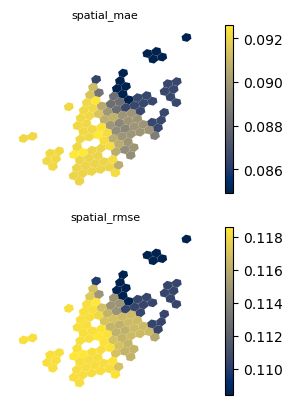

In [214]:
fig, axs = plt.subplots(2, 1)
for i, metric in enumerate(["spatial_mae", "spatial_rmse"]):
    prices_data.plot(metric, ax=axs[i], legend=True, cmap="cividis")
    axs[i].set_title(metric, fontdict={"fontsize": 8})
    axs[i].set_axis_off()

With these data, you can do any of the spatial analysis you are used to,
like extracting local clusters of low or high performance or fixing the
model to avoid these artifacts.

### Spatial dependency of error

Let’s now focus on a direct spatial assessment of residuals. The map of
residuals above indicates that there is some spatial structure to
unpack, so let’s dive into the assessment of the spatial dependency of
the model error.

#### Variogram

Let’s check the spread of the assumed autocorrelation. Is the dependency
relevant only locally, regionally or nationally? To answer this
question, you can build an experimental variogram, like you did when
dealing with kriging. The variogram should then indicate the extent of
autocorrelation.

Remember, that `pyinterpolate` assumes data in a specific structure, so
let’s quickly prepare it. For details check the interpolation chapter.

In [216]:
#calculate residuals
residuals_grid = prices_data["Property Prices"] - prices_data["prediction"]

In [217]:
input_data = np.hstack(
    [
        prices_data.centroid.get_coordinates(),
        residuals_grid.abs().values.reshape(-1, 1),
    ]
)

/var/folders/gl/6m73nrcs3yqd6q9dyxldg7th0000gn/T/ipykernel_4758/1065487963.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prices_data.centroid.get_coordinates(),


Build the variogram, ideally covering the width of the whole country.

In [218]:
exp_semivar = pyinterpolate.build_experimental_variogram(
    input_array=input_data,
    step_size=1,
    max_range=2,
)

With the built semivariogram, you can explore its plot.

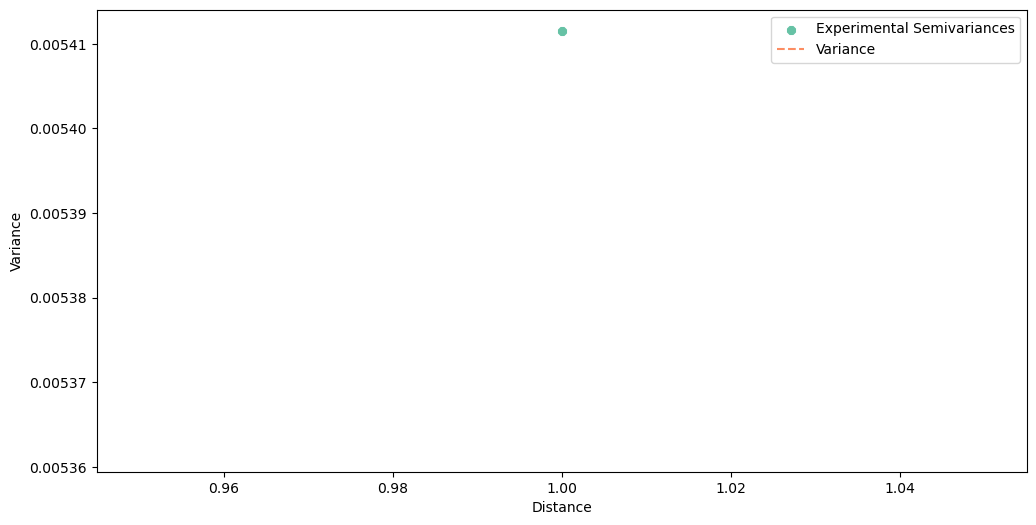

In [219]:
exp_semivar.plot(plot_covariance=False)

The semivariance tends to grow nearly across the whole range, indicating
that the autocorrelation does not disappear when considering larger
regions. More, it seems that there is difference in performance across
large parts of the country. In any case, the results clearly suggests
that the model has a troubles with spatial heterogeneity of the
relationship between independent variables and the target one.

#### LISA on residuals

One approach of determining spatial dependence of the residuals you are
already familiar with is measuring local indicators of spatial
autocorrelation. The variogram does not really help us in selecting the
optimal neighborhood to work with, so let’s build a distance band graph
with the threshold of 10 km.

In [220]:
distance10km = graph.Graph.build_distance_band(
    prices_data.set_geometry(prices_data.centroid), 10_000
)

/var/folders/gl/6m73nrcs3yqd6q9dyxldg7th0000gn/T/ipykernel_4758/1659164644.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prices_data.set_geometry(prices_data.centroid), 10_000


Now, you have two options on how to assess local autocorrelation. When
using the raw residuals, you can identify areas that are consistently
over-predicted and those that are consistently under-predicted.

In [ ]:
moran = esda.Moran_Local(residuals_grid, distance10km, permutations=9999, seed=0)
moran.explore(prices_data, tiles="CartoDB Positron", crit_value=0.1)

High-High clusters are those that are consistently under-predicted while
Low-Low are those consistently over-predicted based on the spatial
distribution of residuals.

Another option is to assess the absolute value of residuals and identify
clusters of consistently correct and consistently wrong locations.

In [ ]:
moran_abs = esda.Moran_Local(residuals_grid.abs(), distance10km, permutations=9999, seed=0)
moran_abs.explore(prices_data, tiles="CartoDB Positron", crit_value=0.1)

This time, High-High captures clusters of high error rates, while
Low-Low areas of low error rate.

## Spatial leakage and spatial cross-validation

When dividing the data into *train* and *test* parts, you are trying to
eliminate data leakage, which happens when information from one set
makes its way to the other. The evaluation affected by leakage then
indicates better results than the reality is. This works well for most
of data, but not so much for spatial data. Tobler’s first law of
geography, which says that nearby things are similar, breaks the
assumption of no leakage. Two geometries that are right next to each
other in space, one randomly allocated to the *train* part and the other
to the *test* part, are not statistically independent. You can assume
that they will be similar, and this similarity caused by the spatial
proximity comes with a potential data leakage.

You can test yourself the degree of spatial autocorrelation of
individual variables used within the model.

In [223]:
rook = graph.Graph.build_contiguity(prices_data)

for variable in independant_variables + ["Property Prices"]:
    morans_i = esda.Moran(prices_data[variable], rook)
    print(f"Moran's I of {variable} is {morans_i.I:.2f} with the  p-value of {morans_i.p_sim}.")

Moran's I of Size is 0.23 with the  p-value of 0.001.
Moran's I of Floor is 0.11 with the  p-value of 0.051.
Moran's I of Units is 0.13 with the  p-value of 0.019.
Moran's I of Parking is 0.02 with the  p-value of 0.284.
Moran's I of Dist. Green is 0.16 with the  p-value of 0.011.
Moran's I of Heating is 0.64 with the  p-value of 0.001.
Moran's I of Dist. Subway is 0.75 with the  p-value of 0.001.
Moran's I of Bus Stop is 0.30 with the  p-value of 0.001.
Moran's I of High School is 0.58 with the  p-value of 0.001.
Moran's I of Property Prices is 0.38 with the  p-value of 0.001.


Every single one of the indicates spatial autocorrelation, meaning that
the spatial leakage is nearly inevitable.

See for yourself how it looks when the data is split into K train-test
folds randomly.

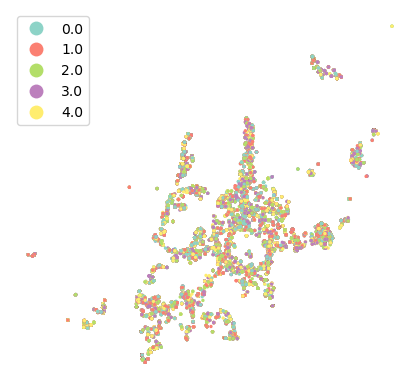

In [224]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

splits = kf.split(independent)

split_label = np.empty(len(independent), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i

prices.plot(
    split_label, categorical=True, legend=True, cmap="Set3", markersize=2
).set_axis_off()

Spatial cross-validation mitigates the issue by including a spatial
dimension in the train-test split. The aim is to divide the whole study
area into smaller regions and allocate whole regions to train and test
splits. You can do that based on many criteria, but it is handy to have
a variable representing those regions as the `"okres"` column in your
DataFrame.

Instead of using `KFold`, use `GroupKFold`, which ensures that
observations are allocated into splits by groups (all observations
within a single group will be in a single split).

In [225]:
gkf = model_selection.GroupKFold(n_splits=5)

In [226]:
independent_grid = prices_data[independant_variables]

Generate the same visualisation as above, with one difference -
specifying the groups.

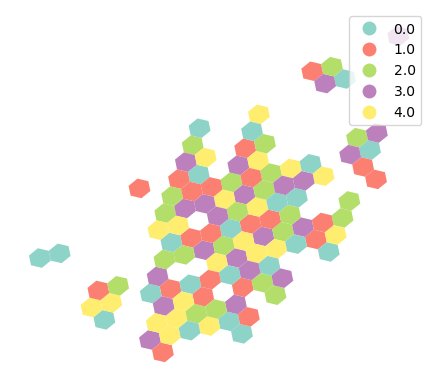

In [227]:
splits = gkf.split(
    independent_grid,
    groups=independent_grid.index
)
split_label = np.empty(len(independent_grid), dtype=float)
for i, (train, test) in enumerate(splits):
    split_label[test] = i

prices_data.plot(
    split_label, categorical=True, legend=True, cmap="Set3"
).set_axis_off()

In [228]:
prices

,Property Prices,Longitude,Latitude,Size,Floor,Highest floor,Units,Parking,Heating,Year,...,Pop. Density,Higher Degree,Young Population,Median Age,Old Population,Spring,Fall,Winter,geometry,prediction
0,9.798127,129.108144,35.215019,45.0700,8,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,0,0,1,POINT (129.10814 35.21502),9.748952
1,9.852194,129.108144,35.215019,38.1000,13,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,1,0,0,POINT (129.10814 35.21502),9.683773
2,9.740969,129.108144,35.215019,45.0700,6,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,1,0,0,POINT (129.10814 35.21502),9.746924
3,9.798127,129.108144,35.215019,38.1000,13,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,0,0,0,POINT (129.10814 35.21502),9.683773
4,9.692767,129.108144,35.215019,38.1000,7,13.0,84.0,0.67,0,2017,...,1637.044855,46.392339,26.284572,55.4,5.712075,0,0,0,POINT (129.10814 35.21502),9.674856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52639,9.698920,129.113508,35.162987,37.1974,20,21.0,298.0,1.33,0,2015,...,21540.983607,26.619513,8.542618,32.7,17.226027,0,1,0,POINT (129.11351 35.16299),9.745288
52640,9.615805,129.113508,35.162987,37.1974,6,21.0,298.0,1.33,0,2015,...,21540.983607,26.619513,8.542618,32.7,17.226027,0,1,0,POINT (129.11351 35.16299),9.704607
52641,9.740969,129.113508,35.162987,37.1974,12,21.0,298.0,1.33,0,2015,...,21540.983607,26.619513,8.542618,32.7,17.226027,0,0,1,POINT (129.11351 35.16299),9.686320
52642,9.732106,129.113508,35.162987,49.9637,5,21.0,298.0,1.33,0,2015,...,21540.983607,26.619513,8.542618,32.7,17.226027,0,0,1,POINT (129.11351 35.16299),9.849834


In [229]:
#spatial join for prices and prices_data
prices_group = gpd.sjoin(prices, prices_data, how="right")


Cross-validated prediction can then be performed using these splits,
ensuring that the spatial leakage between test and train is limited in
each fold.

In [231]:
rf_spatial_cv = ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)

pred_spatial_cv = model_selection.cross_val_predict(
    rf_spatial_cv,
    independent,
    target,
    groups=prices_group.index,
    cv=gkf,
    n_jobs=-1,
)

The rest can follow the same pattern.

In [232]:
r2_spatial_cv = metrics.r2_score(target, pred_spatial_cv)
mae_spatial_cv = metrics.mean_absolute_error(target, pred_spatial_cv)
rmse_spatial_cv = metrics.root_mean_squared_error(target, pred_spatial_cv)

summary += f"""\
Random Forest with spatial cross-validation (k-fold):
  R2:   {round(r2_spatial_cv, 3)}
  MAE:  {round(mae_spatial_cv, 3)}
  RMSE: {round(rmse_spatial_cv, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.961
  MAE:  0.072
  RMSE: 0.111
Random Forest (k-fold metrics):
  R2:   0.856
  MAE:  0.159
  RMSE: 0.215
Random Forest with spatial cross-validation (k-fold):
  R2:   0.842
  MAE:  0.164
  RMSE: 0.226



The models with spatial cross-validation usually show worse performance
than those with the random one but that is expected. The difference is
due to elimination of the spatial leakage and hence improving the
robustness of the model, meaning that on unseen data, it will perform
better (contrary to the change in the metrics).

## Model comparison

Now that you know how to embed geography in train-test splits and in the
model evaluation, let’s have a look at some other models than Random
Forest.

The API of them all will be mostly the same but note that some (like
support vector regressor for example), may need data standardisation.
For a comparison, check the performance of out-of-the-shelf Gradient
Boosted Tree on our data using the spatial cross-validation.

In [233]:
boosted_tree = ensemble.GradientBoostingRegressor()
pred_boosted_tree = model_selection.cross_val_predict(
    boosted_tree,
    independent,
    target,
    groups=prices_group.index,
    cv=gkf,
)

r2_boosted_tree = metrics.r2_score(target, pred_boosted_tree)
mae_boosted_tree = metrics.mean_absolute_error(target, pred_boosted_tree)
rmse_boosted_tree = metrics.root_mean_squared_error(target, pred_boosted_tree)

summary += f"""\
Gradient Boosted Tree with spatial cross-validation (k-fold):
  R2:   {round(r2_boosted_tree, 3)}
  MAE:  {round(mae_boosted_tree, 3)}
  RMSE: {round(rmse_boosted_tree, 3)}
"""
print(summary)

Evaluation metrics
Random Forest:
  R2:   0.961
  MAE:  0.072
  RMSE: 0.111
Random Forest (k-fold metrics):
  R2:   0.856
  MAE:  0.159
  RMSE: 0.215
Random Forest with spatial cross-validation (k-fold):
  R2:   0.842
  MAE:  0.164
  RMSE: 0.226
Gradient Boosted Tree with spatial cross-validation (k-fold):
  R2:   0.78
  MAE:  0.206
  RMSE: 0.266



As you can see, the gradient boosted tree over-performs the random
forest model. However, using the default parameters may not yield the
optimal model.

### Hyper-parameter tuning

When searching for an optimal model, you shall test different
hyper-parameters. Let’s stick to the gradient boosted tree for now and
test the performance of a sequence of models comparing different way of
measuring the loss and different learning rates.

In [234]:
param_grid = {
    "loss": ["squared_error", "absolute_error"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
}

boosted_tree = ensemble.GradientBoostingRegressor(random_state=0)

grid_search = model_selection.GridSearchCV(
    boosted_tree, param_grid, cv=gkf
)
grid_search.fit(independent, target, groups=prices_group.index)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'loss': ['squared_error', 'absolute_error']})

Large grid searches may take a while as there’s often a lot of models to
train. The result contains many pieces of information, from score and
parameters to time required to train each model.

Let’s extract the mean test scores per each model and figure out which
parameters are the best in this case.

In [235]:
params = grid_search.cv_results_["params"]
mean_scores = grid_search.cv_results_["mean_test_score"]

grid_search_results = pd.DataFrame(params)
grid_search_results["mean_score"] = mean_scores
grid_search_results.sort_values("mean_score", ascending=False)

,learning_rate,loss,mean_score
8,0.20,squared_error,0.802002
6,0.15,squared_error,0.796890
9,0.20,absolute_error,0.785381
4,0.10,squared_error,0.776860
7,0.15,absolute_error,0.774055
5,0.10,absolute_error,0.763594
2,0.05,squared_error,0.752035
3,0.05,absolute_error,0.737793
0,0.01,squared_error,0.570859
1,0.01,absolute_error,0.547655


The best model seems to be use learning rate of 0.15 and absolute error
as a measure of loss. The score here is $R^2$, so you may wonder how
come it is smaller than before? It is a mean of 5 folds, not a single
score derived from cross-validated prediction, hence the number has
slightly different properties. Remember, $R^2$, while being usually in
the same ballpark range, is not directly comparable across datasets.

## Feature importance

There is one more question you may ask. What is driving the results?

Get the best model from the grid search and explore the importance of
individual independent variables.

In [236]:
best_model = grid_search.best_estimator_

Feature importance is not directly comparable to $\beta$ coefficients.
The values sum to 1 and indicate the normalised reduction of the loss
brought by each feature. The higher the value, the more important the
feature is within the model.

In [237]:
feature_importance = pd.Series(
    best_model.feature_importances_, index=independant_variables
)
feature_importance.sort_values()

Bus Stop        0.005110
Heating         0.006299
High School     0.010619
Floor           0.015688
Dist. Green     0.016432
Units           0.047231
Dist. Subway    0.066012
Parking         0.246268
Size            0.586340
dtype: float64

Two out of the six independent variables account for mode than 66% of
the model performance. Let’s see that visually.

<Axes: >

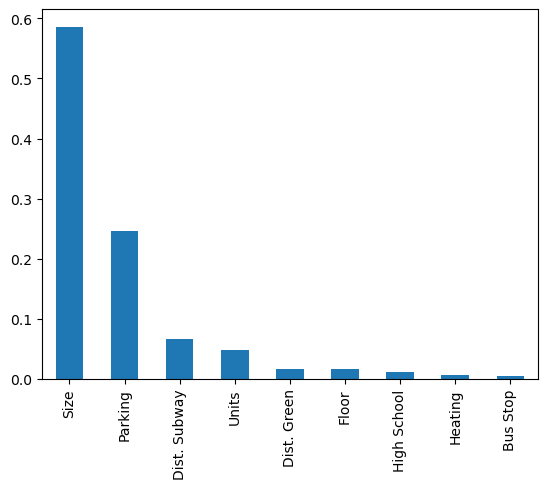

In [238]:
feature_importance.sort_values(ascending=False).plot.bar()

The rate of divorces playing a role is a bit expected. What is really
interesting is that the most important variable is the proportion of
population with *undetermined* education level. While many other types
of information are coming from various national registries, the
education is likely dependent on the information provided during the
Census. And it seems, that people who struggle with executions do not
trust the government enough, to provide such a basic data.

You can compare the original baseline model with the “best” one
spatially or try to get a Random Forest that outperforms this Gradient
Boosted Tree. There is a lot to play with.

> **Additional reading**
>
> This material has intentionally omitted a lot of ML basics. Go and
> check the [User
> Guide](https://scikit-learn.org/stable/user_guide.html) of
> scikit-learn to catch up with it yourself.